# Chapter 7 - Moving Beyond Linearity

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-5421.2466887,1.546580e+03,-3.505313,0.0006921695
"poly(x, 2, raw = TRUE)1",77.7075083,2.197402e+01,3.536336,0.0006240344
"poly(x, 2, raw = TRUE)2",-0.2784125,7.805107e-02,-3.567055,0.0005628472


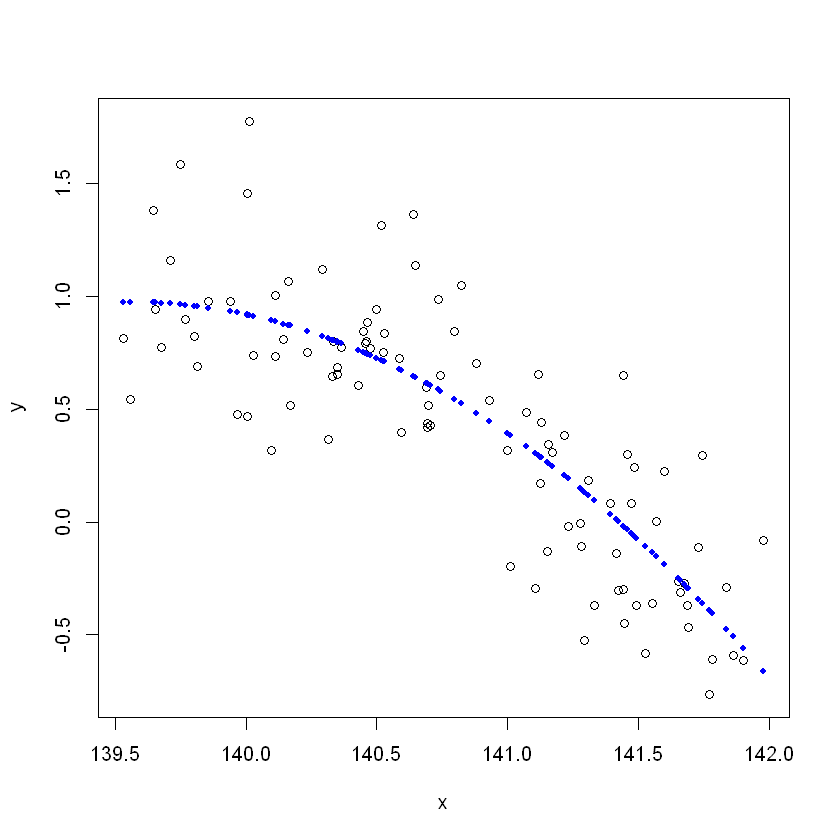

In [8]:
load("data/7.R.RData")
fit <- lm(y ~ poly(x, 2, raw = TRUE)) # raw = TRUE constraints the use of x,x^2 and not orthogonal polynomial 
coef(summary(fit))
plot(y ~ x)
points(x, fitted(fit), col ='blue', pch=20)